# Retain or Resign: Decoding the 'Why' Behind Employee Turnover with Data

## Import Libraries dan Dataset

In [506]:
# install dependencies
!pip install -q category_encoders shap imbalanced-learn xgboost joblib

In [507]:
# ini adalah library utama
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# lanjutan
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve,
                             average_precision_score, roc_auc_score, roc_curve, precision_score, recall_score,
                             f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

# model opsional
import xgboost as xgb

# target encoding
import category_encoders as ce

# keras and tensorflow
import tensorflow as tf

# shap
import shap

In [508]:
# kita akan melakukan mounting di google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [509]:
# baca dataset sesuai path yang ada
df = pd.read_csv('/content/drive/MyDrive/Data Portofolio/Human_Resources.csv')

In [510]:
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


In [511]:
# lihat 5 data awal
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [512]:
# lihat 5 data akhir
df.tail()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8
1469,34,No,Travel_Rarely,628,Research & Development,8,3,Medical,1,2068,...,1,80,0,6,3,4,4,3,1,2


In [513]:
# overview dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [514]:
# summary statistik secara keseluruhan
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


## Visualisasi Dataset

In [515]:
# kita akan mengubah kolom 'attrition','overtime', dan 'over18' dengan angka 1/0 sebelum melakukan visualisasi
# disini konteksnya 1 == Yes dan 0 == No
df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
df['OverTime'] = df['OverTime'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Over18'] = df['Over18'].apply(lambda x: 1 if x == 'Y' else 0)

In [516]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


<Axes: >

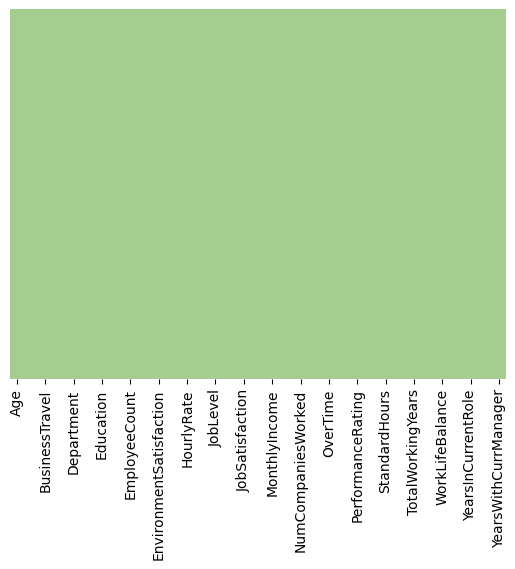

In [517]:
# kita akan mencoba untuk melihat apakah ada missing data dengan heatmap
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'crest')

dapat dilihat disini kita tidak memiliki missing value dalam dataset

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Attrition'}>,
        <Axes: title={'center': 'DailyRate'}>,
        <Axes: title={'center': 'DistanceFromHome'}>,
        <Axes: title={'center': 'Education'}>],
       [<Axes: title={'center': 'EmployeeCount'}>,
        <Axes: title={'center': 'EmployeeNumber'}>,
        <Axes: title={'center': 'EnvironmentSatisfaction'}>,
        <Axes: title={'center': 'HourlyRate'}>,
        <Axes: title={'center': 'JobInvolvement'}>],
       [<Axes: title={'center': 'JobLevel'}>,
        <Axes: title={'center': 'JobSatisfaction'}>,
        <Axes: title={'center': 'MonthlyIncome'}>,
        <Axes: title={'center': 'MonthlyRate'}>,
        <Axes: title={'center': 'NumCompaniesWorked'}>],
       [<Axes: title={'center': 'Over18'}>,
        <Axes: title={'center': 'OverTime'}>,
        <Axes: title={'center': 'PercentSalaryHike'}>,
        <Axes: title={'center': 'PerformanceRating'}>,
        <Axes: title={'center': 'Relations

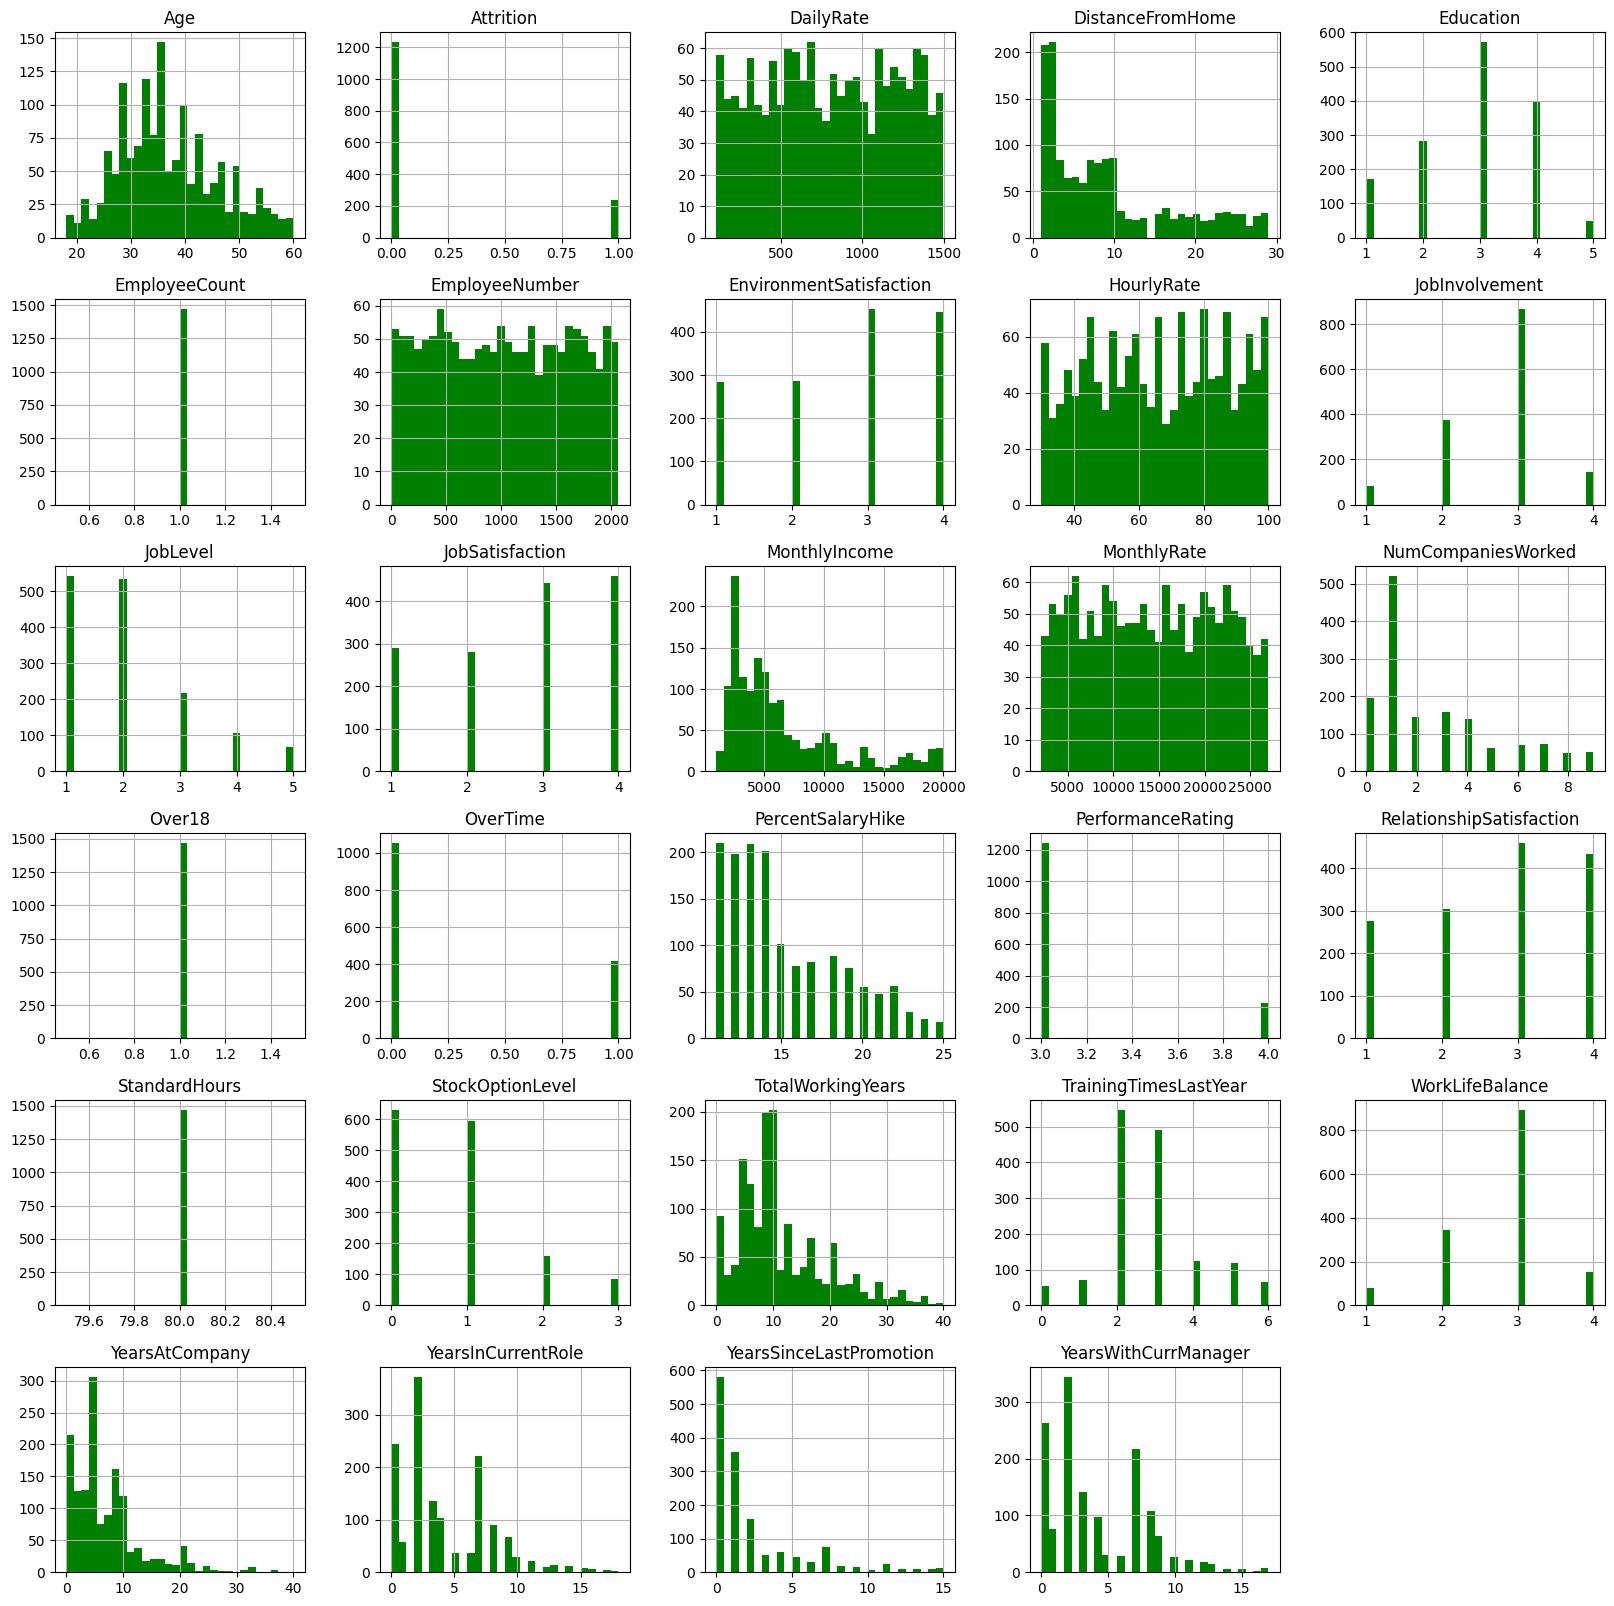

In [518]:
# kita akan menggunakan histogram untuk melihat persebaran data pada setiap kolom
df.hist(bins= 30,figsize=(20,20),color='g')

dari histogram tersebut kita bisa melihat beberapa hal :


*   Beberapa fitur seperti **'MonthlyIncome'** (Pendapatan Bulanan) dan **'TotalWorkingYears'** (Total Tahun Bekerja) memiliki distribusi yang tail heavy (ekornya panjang).
*  kita dapat menghapus fitur **'EmployeeCount'** (Jumlah Karyawan) dan **'StandardHours'** (Jam Standar) dan **'Over18'** karena nilainya tidak berubah dari satu karyawan ke karyawan lainnya.

In [519]:
# disini saya memutuskan untuk menghapus 4 kolom sekaligus , yaitu 3 kolom yang nilainya tidak berubah dan kolom 'employeenumber' karena ini hanyalah nomor karyawan
df.drop(['EmployeeCount','StandardHours','Over18','EmployeeNumber'],axis=1,inplace=True)

In [520]:
# disini saya melakukan copy dataframe sehingga bisa dipakai untuk improvement bila diperlukan
df_copy = df.copy()

In [521]:
# kita akan membuat dua dataframe . yang satu untuk melihat yang left dan yang stayed
left = df[df['Attrition']==1]
stayed = df[df['Attrition']==0]

In [522]:
# kita akan melihat berapa banyak employee yang stayed dan left
print('total pegawai =',len(df))

print('jumlah pegawai yang left(keluar) =',len(left))
print('persentase yang keluar =', 1.*len(left)/len(df)*100,'%')
print('jumlah pegawai yang stay(tetap) =',len(stayed))
print('persentase yang tetap =', 1.*len(stayed)/len(df)*100,'%')

total pegawai = 1470
jumlah pegawai yang left(keluar) = 237
persentase yang keluar = 16.122448979591837 %
jumlah pegawai yang stay(tetap) = 1233
persentase yang tetap = 83.87755102040816 %


In [523]:
# kita akan melihat perbedaan dua kelompok tersebut dari segi statistik
left.describe()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,237.000000,237.0,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,...,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
mean,33.607595,1.0,750.362869,10.632911,2.839662,2.464135,65.573840,2.518987,1.637131,2.468354,...,3.156118,2.599156,0.527426,8.244726,2.624473,2.658228,5.130802,2.902954,1.945148,2.852321
std,9.689350,0.0,401.899519,8.452525,1.008244,1.169791,20.099958,0.773405,0.940594,1.118058,...,0.363735,1.125437,0.856361,7.169204,1.254784,0.816453,5.949984,3.174827,3.153077,3.143349
min,18.000000,1.0,103.000000,1.000000,1.000000,1.000000,31.000000,1.000000,1.000000,1.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,1.0,408.000000,3.000000,2.000000,1.000000,50.000000,2.000000,1.000000,1.000000,...,3.000000,2.000000,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,32.000000,1.0,699.000000,9.000000,3.000000,3.000000,66.000000,3.000000,1.000000,3.000000,...,3.000000,3.000000,0.000000,7.000000,2.000000,3.000000,3.000000,2.000000,1.000000,2.000000
75%,39.000000,1.0,1092.000000,17.000000,4.000000,4.000000,84.000000,3.000000,2.000000,3.000000,...,3.000000,4.000000,1.000000,10.000000,3.000000,3.000000,7.000000,4.000000,2.000000,5.000000
max,58.000000,1.0,1496.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,...,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,15.000000,15.000000,14.000000


In [524]:
stayed.describe()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1233.000000,1233.0,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,...,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000
mean,37.561233,0.0,812.504461,8.915653,2.927007,2.771290,65.952149,2.770479,2.145985,2.778589,...,3.153285,2.733982,0.845093,11.862936,2.832928,2.781022,7.369019,4.484185,2.234388,4.367397
std,8.888360,0.0,403.208379,8.012633,1.027002,1.071132,20.380754,0.692050,1.117933,1.093277,...,0.360408,1.071603,0.841985,7.760719,1.293585,0.681907,6.096298,3.649402,3.234762,3.594116
min,18.000000,0.0,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,0.0,477.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,...,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,0.0,817.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,...,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,6.000000,3.000000,1.000000,3.000000
75%,43.000000,0.0,1176.000000,13.000000,4.000000,4.000000,83.000000,3.000000,3.000000,4.000000,...,3.000000,4.000000,1.000000,16.000000,3.000000,3.000000,10.000000,7.000000,3.000000,7.000000
max,60.000000,0.0,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,...,4.000000,4.000000,3.000000,38.000000,6.000000,4.000000,37.000000,18.000000,15.000000,17.000000


ada perbedaan yang bisa kita amati dari dua kelompok tersebut :    


*   **rata-rata umur** pegawai yang menetap lebih tinggi daripada yang keluar (37>33)
*   dari segi **daily rate** (tingkat upah harian) pegawai yang menetap lebih tinggi
* dari segi jarak pada kolom **'DistanceFromHome'** , bisa dilihat bahwa Karyawan yang bertahan tinggal lebih dekat dari rumah
* **'EnvironmentSatisfaction' & 'JobSatisfaction'**: Karyawan yang bertahan pada umumnya lebih puas dengan lingkungan dan pekerjaan mereka.
* **'StockOptionLevel'**: Karyawan yang bertahan cenderung memiliki tingkat opsi saham yang lebih tinggi.

<Axes: >

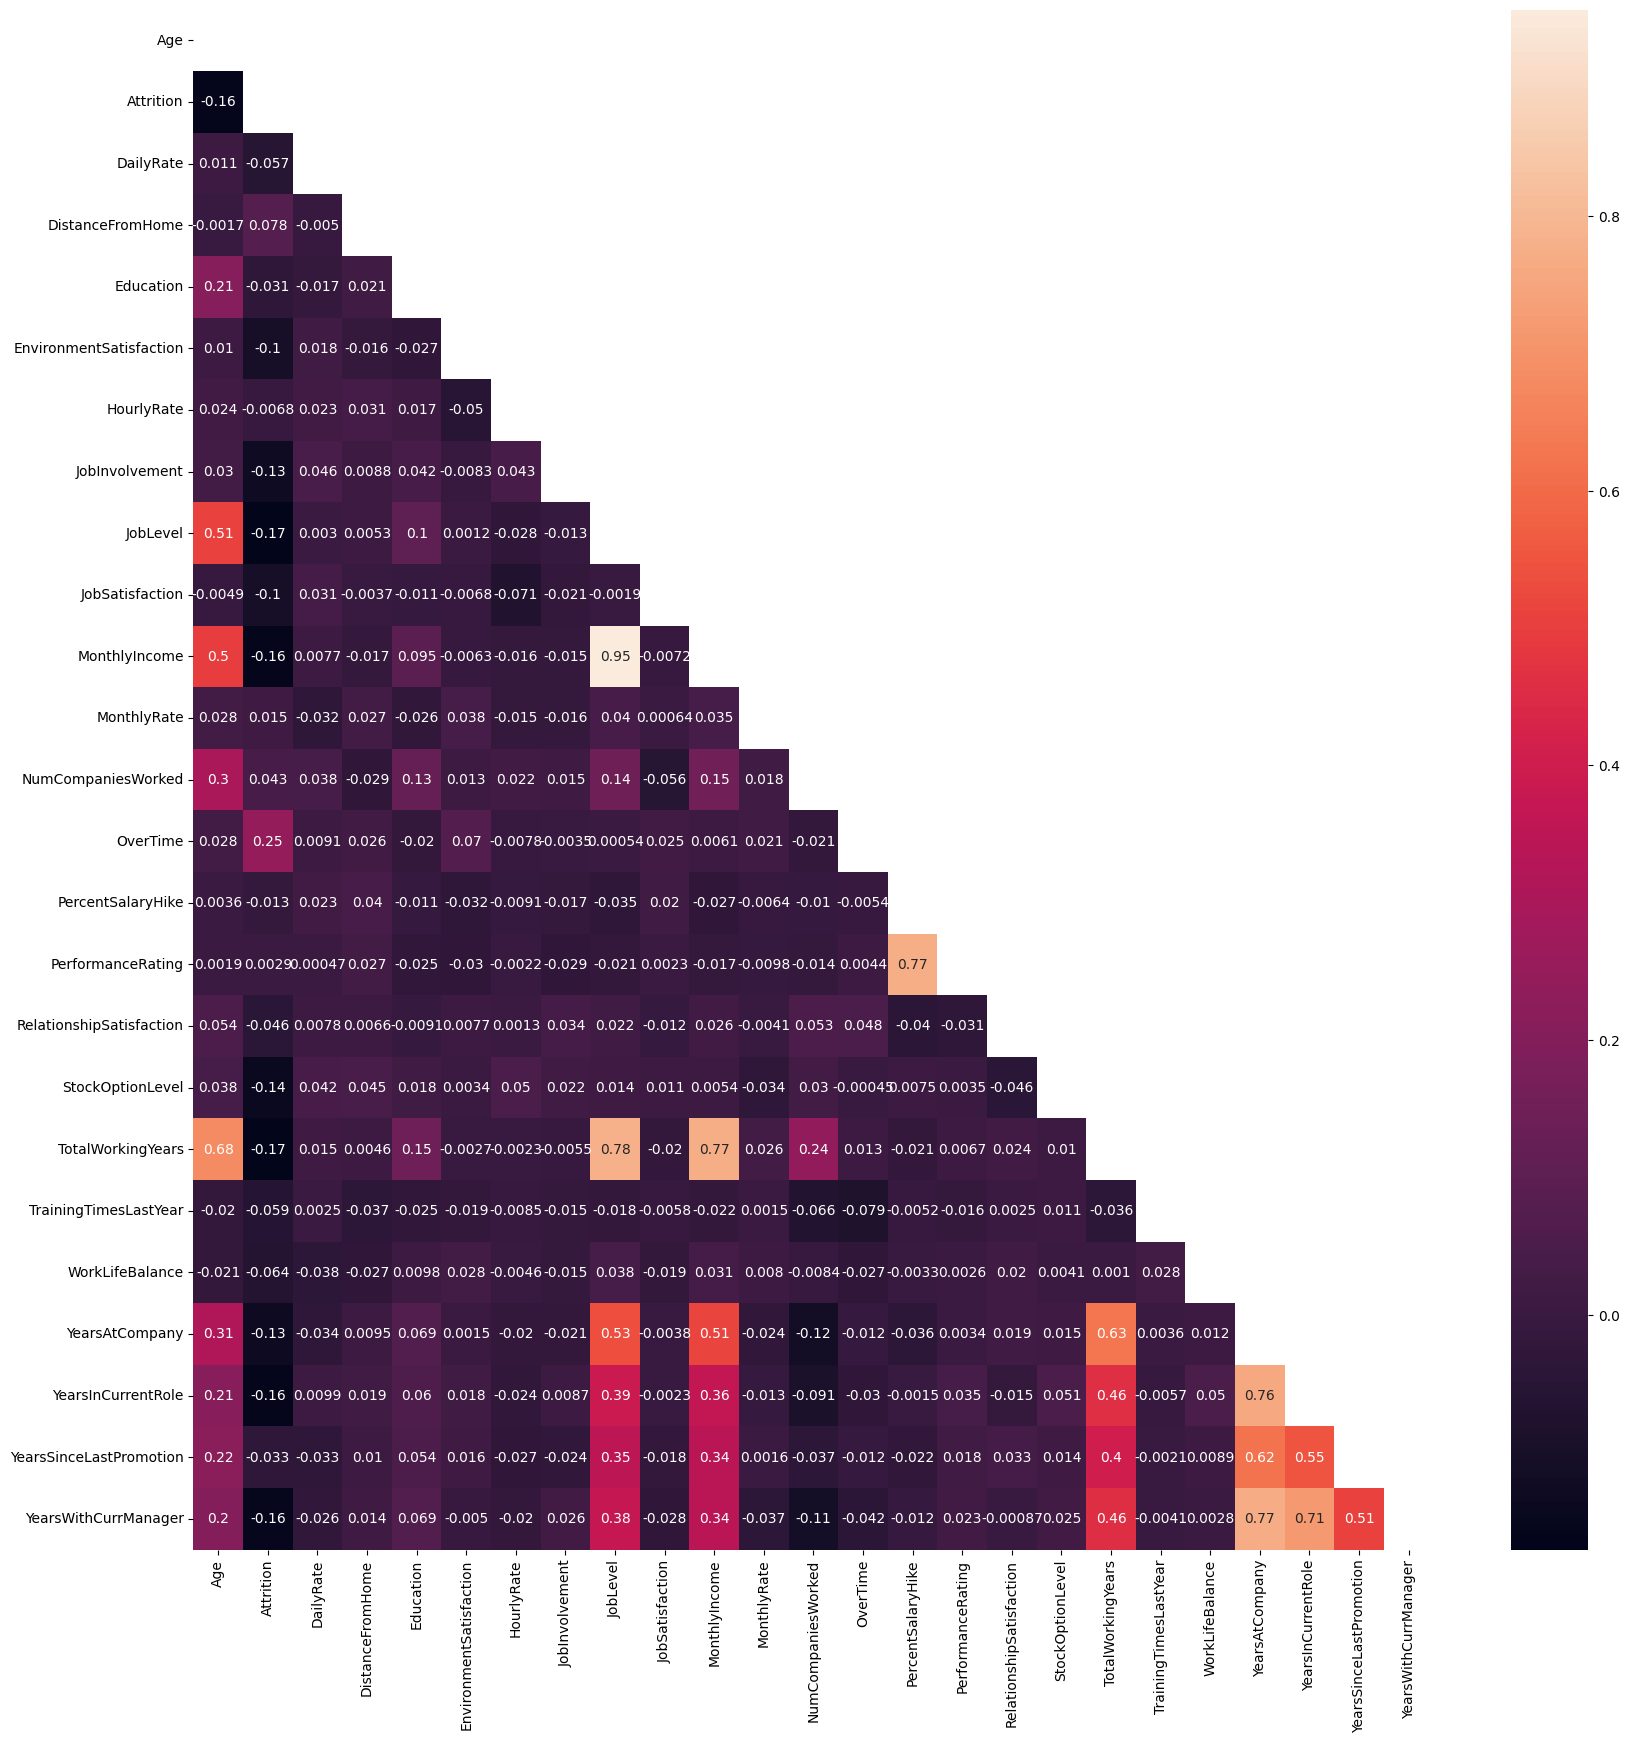

In [525]:
correlations = df.select_dtypes(include='number').corr()
mask = np.triu(np.ones_like(correlations, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(correlations, mask=mask, annot=True)

disini kita melihat bahwa beberapa kolom memiliki korelasi kuat satu sama lain . diantaranya adalah :    

*   Tingkat jabatan berkorelasi kuat dengan total jam kerja
*   Pendapatan bulanan berkorelasi kuat dengan tingkat jabatan
* Pendapatan bulanan berkorelasi kuat dengan total jam kerja
* Usia berkorelasi kuat dengan pendapatan bulanan

dan beberapa korelasi lainnya yang bisa dilihat pada heatmap.


<Axes: xlabel='Age', ylabel='count'>

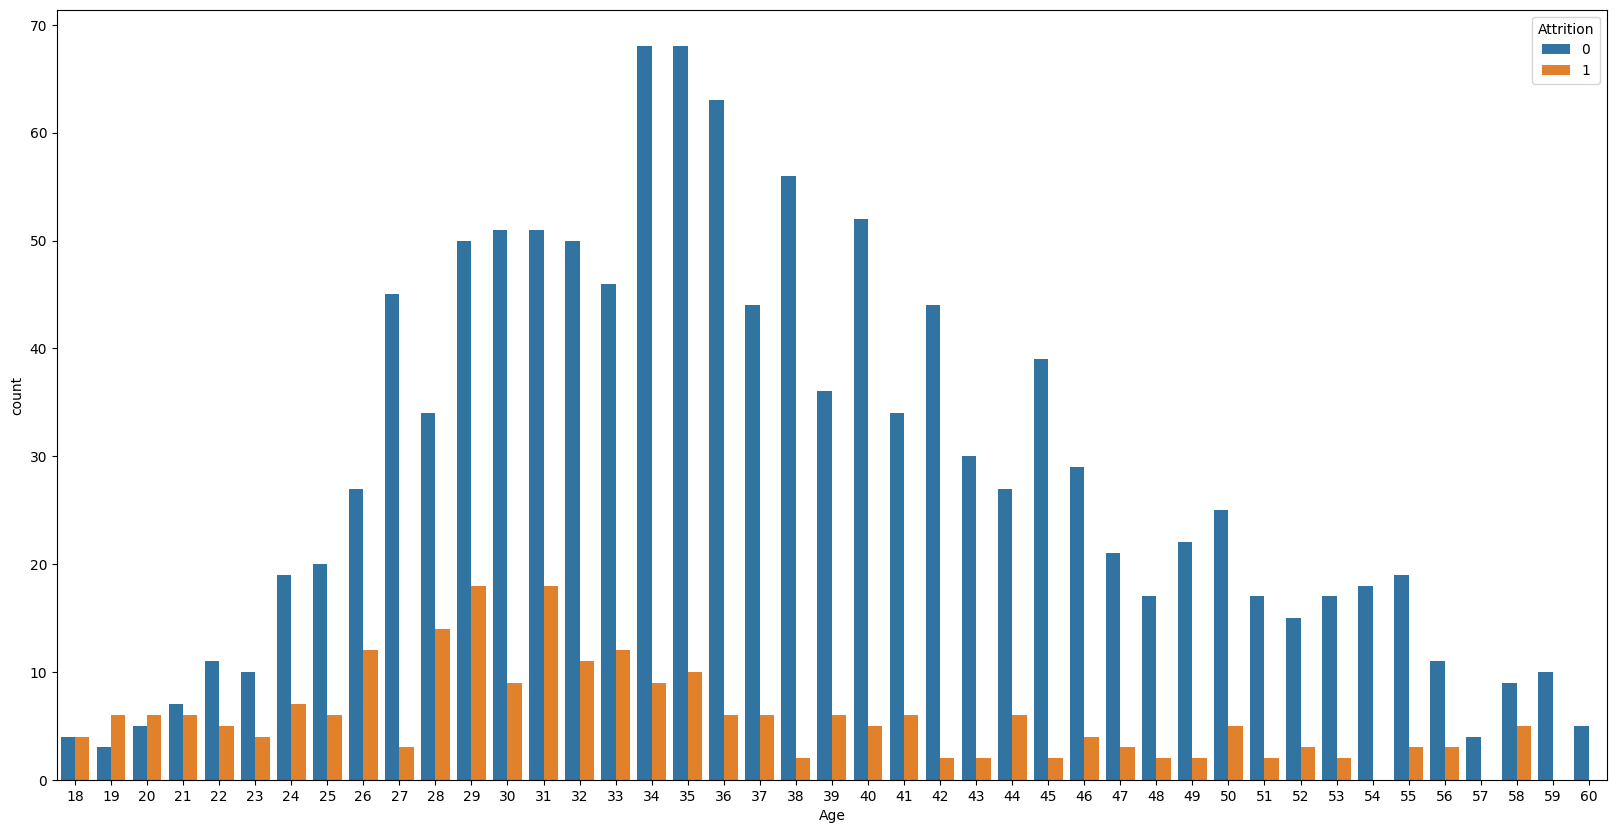

In [526]:
# kita akan melihat hubungan umur dengan attrition dengan lebih jelas menggunakan countplot
plt.figure(figsize=(20,10))
sns.countplot(x='Age',hue='Attrition',data=df)

kita bisa melihat bahwa ada trend 'left' yang tinggi pada range usia 28 hingga 31 tahun . hal ini mungkin bisa diasosiasikan segmen usia tersebut masih dalam masa eksplorasi dan coba - coba sehingga memiliki attrition level yang cukup tinggi

kita juga bisa melihat bahwa pada usia termuda yaitu 18 tahun , trend left dan stay sama besarnya . sedangkan untuk pegawai yang memiliki umur cukup tua memiliki tren attrition yang cenderung sedikit .

<Axes: xlabel='JobLevel', ylabel='count'>

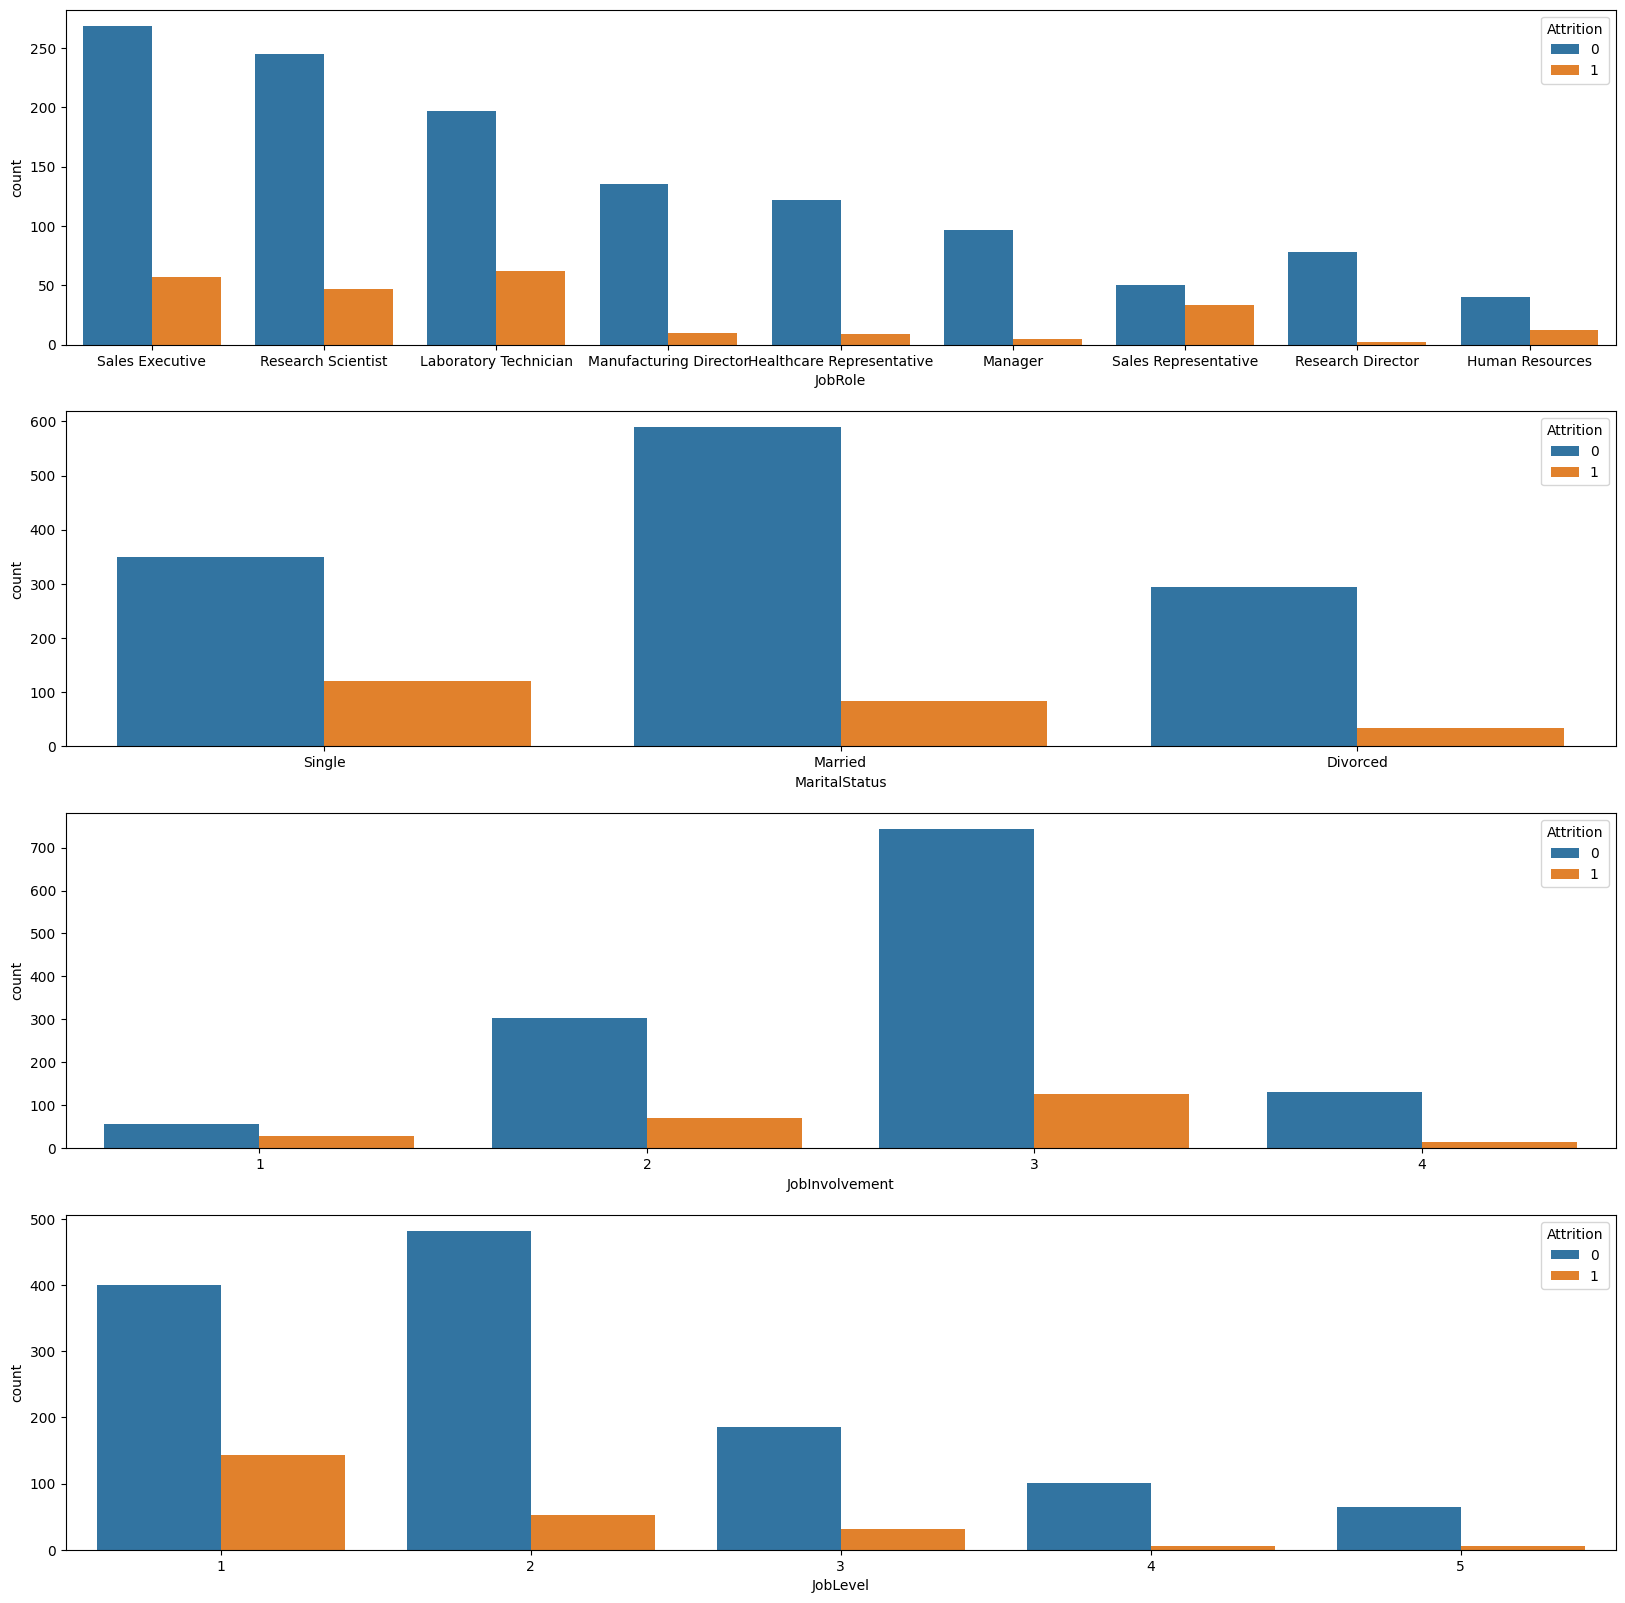

In [527]:
plt.figure(figsize=[20,20])
plt.subplot(411)
sns.countplot(x='JobRole',hue='Attrition',data=df)
plt.subplot(412)
sns.countplot(x='MaritalStatus',hue='Attrition',data=df)
plt.subplot(413)
sns.countplot(x='JobInvolvement',hue='Attrition',data=df)
plt.subplot(414)
sns.countplot(x='JobLevel',hue='Attrition',data=df)

dari visualisasi keempat countplot ini , kita dapat melihat beberapa hal :    


*   pada jobrole 'sales representative' rasio attritionnya sangat tinggi . mungkin ada hal tertentu yang membuat kondisi demikian .
*   pada marital status kita bisa melihat bahwa single memiliki angka attrition yang tinggi
* pegawai dengan kategori jobinvolvement rendah yaitu 1 memiliki jumlah stayed dan left yang sama sama rendah dan pada kategori 4 yang merupakan level maksimal , kita bisa melihat bahwa hanya ada sedikit attrition
* begitu juga dengan joblevel , kita bisa melihat bahwa pada joblevel '1' yang merupakan entry level attritionnya sangat tinggi . ketika joblevel naik , kita bisa melihat tren attritionnya turun seiring kenaikan tersebut



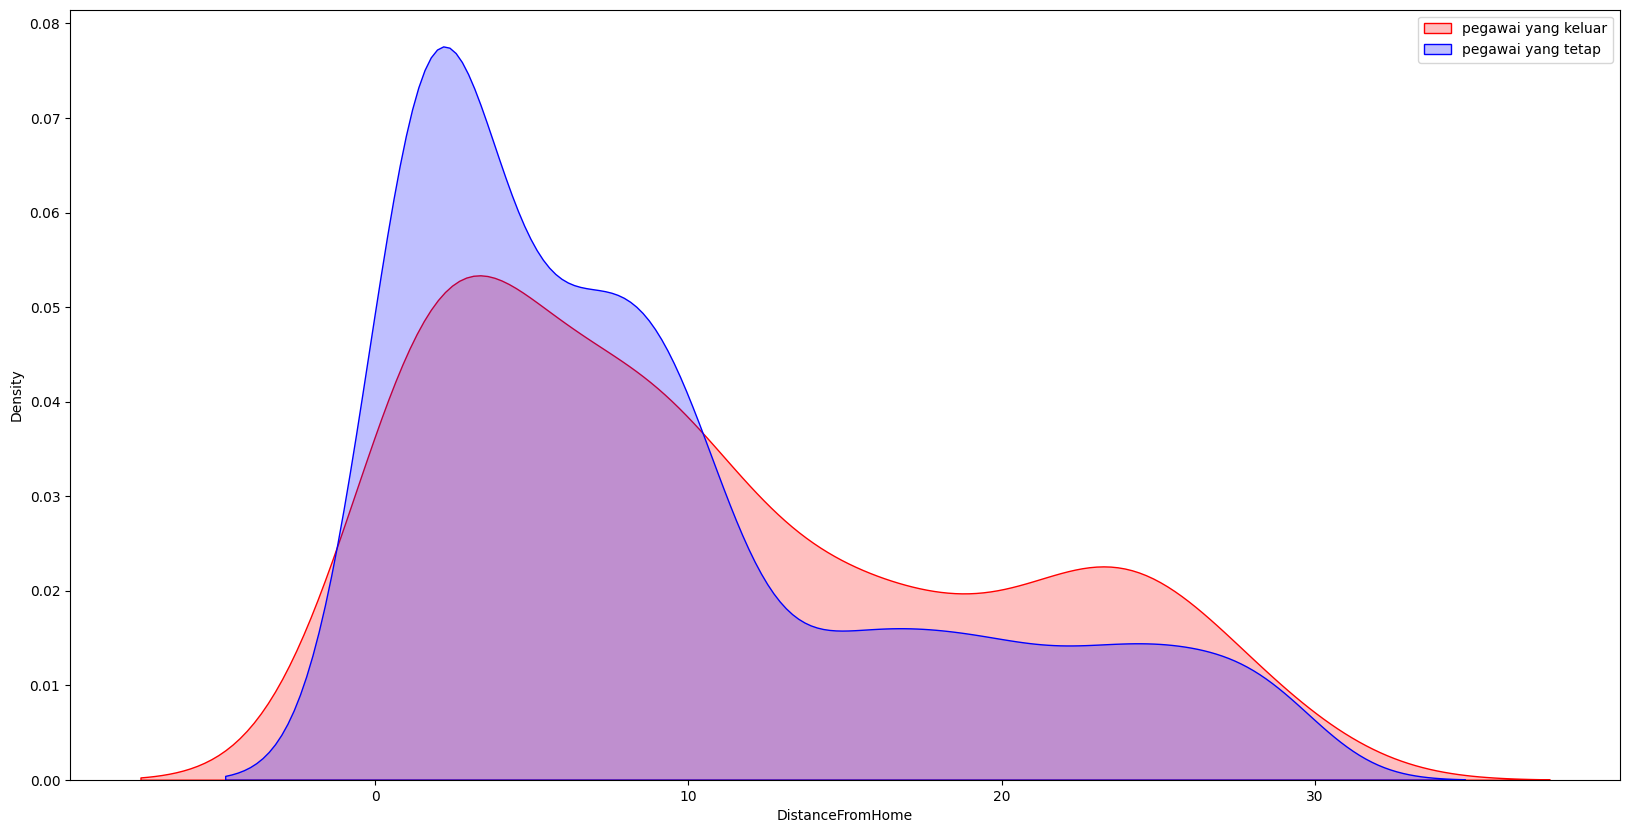

In [528]:
# kita akan melihat probability density dengan KDE plot
# KDE menggambarkan kepadatan probabilitas
plt.figure(figsize=(20,10))
sns.kdeplot(left['DistanceFromHome'],label='pegawai yang keluar',fill=True,color= 'r')
sns.kdeplot(stayed['DistanceFromHome'],label='pegawai yang tetap',fill=True,color='b')
plt.legend()

disini kita dapat melihat bahwa pegawai yang memiliki jarak dari rumah diatas 10km memiliki komposisi left yang lebih banyak dibanding yang memilih stay . hal ini bisa berarti bahwa para pegawai yang keluar mungkin mempertimbangkan jarak rumah dengan tempat bekerja sehingga memutuskan untuk left

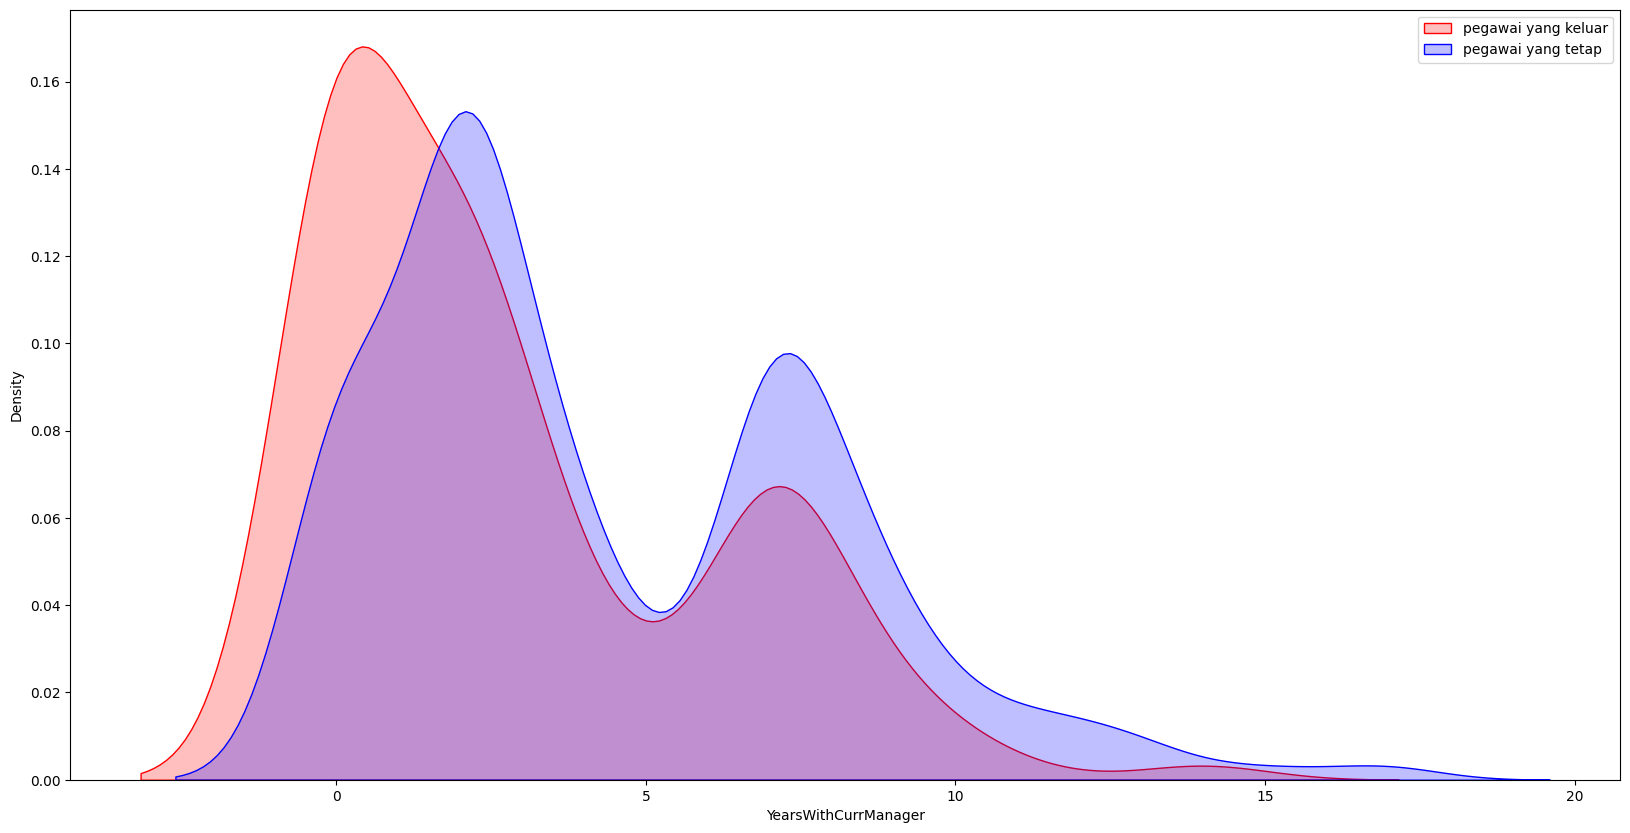

In [529]:
plt.figure(figsize=(20,10))
sns.kdeplot(left['YearsWithCurrManager'],label='pegawai yang keluar',fill=True,color= 'r')
sns.kdeplot(stayed['YearsWithCurrManager'],label='pegawai yang tetap',fill=True,color='b')
plt.legend()

kita dapat melihat bahwa pegawai baru yang baru bekerja sebentar dengan manajer cenderung lebih banyak keluar dengan cepat . pegawai yang sudah melewati sekitar 6-7 tahun biasanya lebih stabil dan bertahan

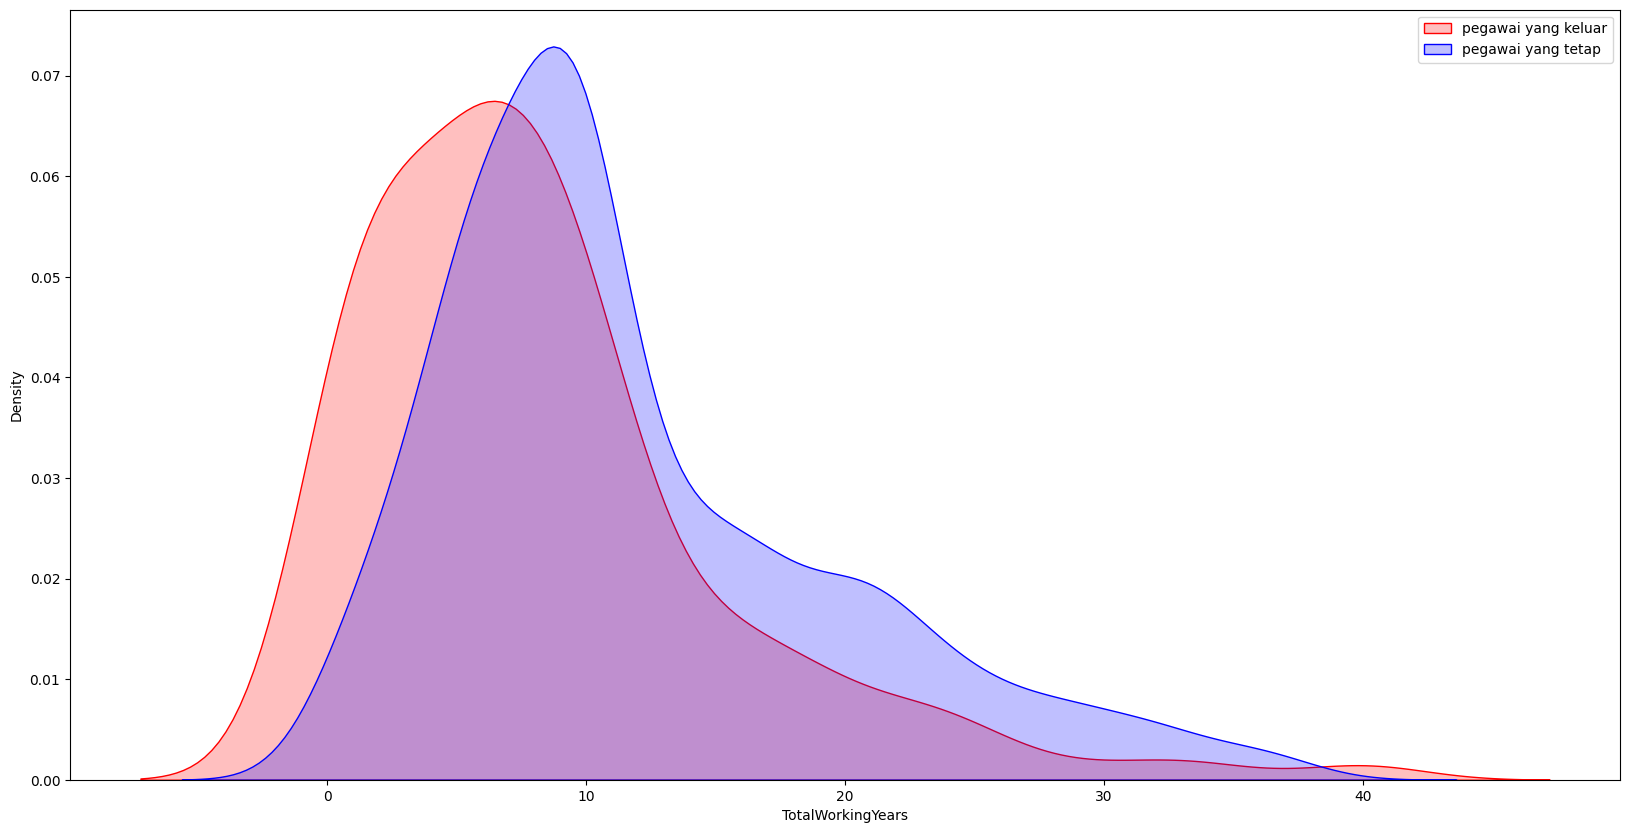

In [530]:
plt.figure(figsize=(20,10))
sns.kdeplot(left['TotalWorkingYears'],label='pegawai yang keluar',fill=True,color= 'r')
sns.kdeplot(stayed['TotalWorkingYears'],label='pegawai yang tetap',fill=True,color='b')
plt.legend()

kita bisa melihat bahwa pegawai yang keluar lebih banyak proporsinya dibanding yang bertahan ketika masa awal (0-5 tahun) . hal ini mungkin disebabkan karena mereka masih mencari tempat kerja yang sesuai atau belum terikat kuat dengan perusahaan.

/tmp/ipython-input-772519773.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='MonthlyIncome',y='Gender',data=df,palette='Set1')


<Axes: xlabel='MonthlyIncome', ylabel='Gender'>

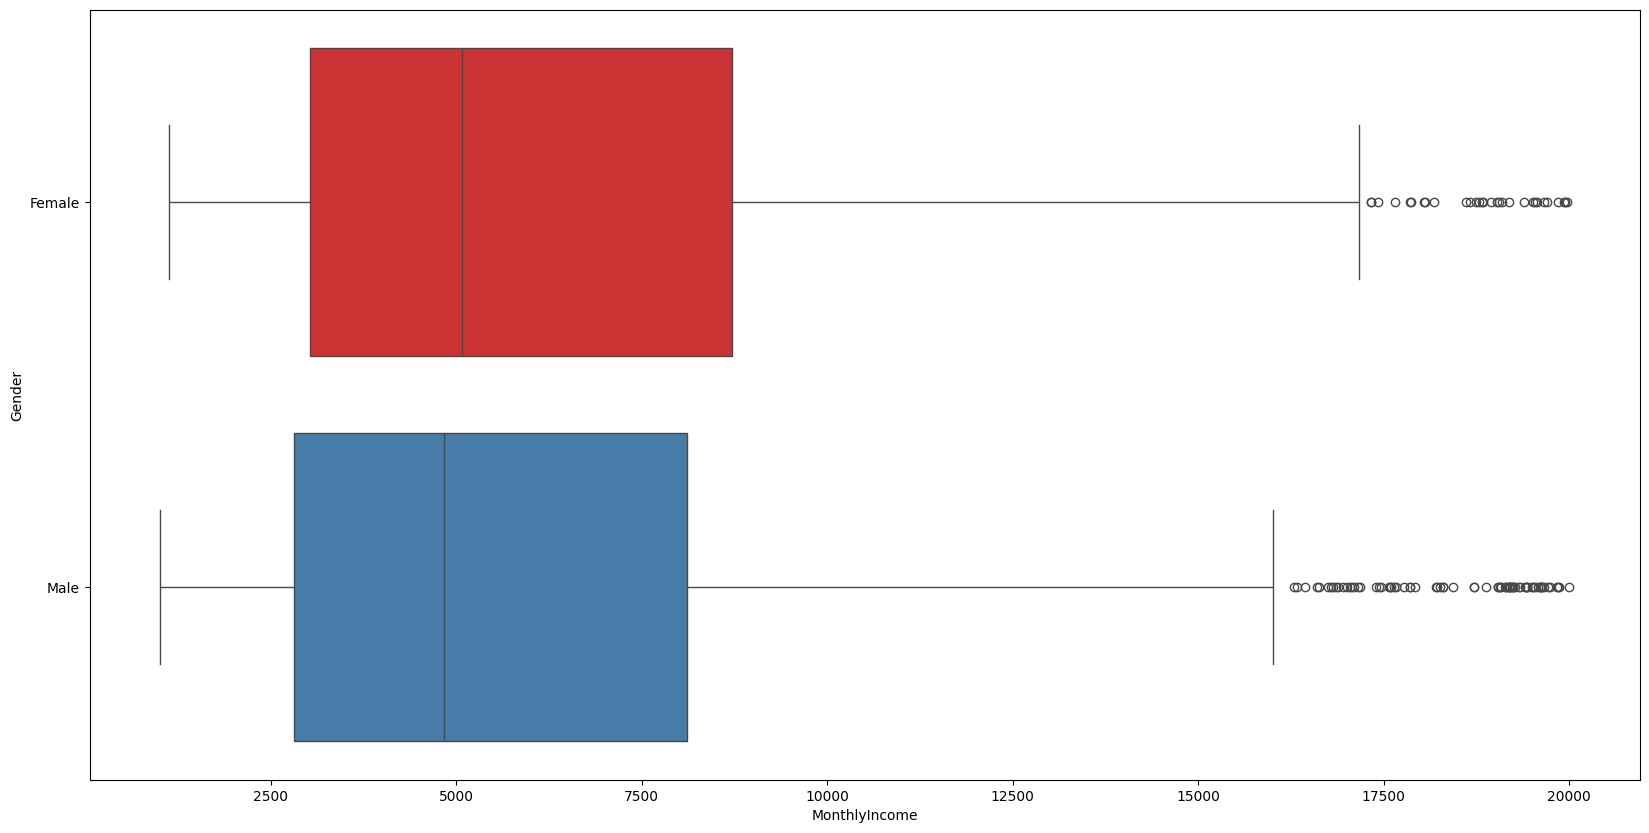

In [531]:
# kita akan menggunakan boxplot untuk melihat perbandingan gender vs monthly income
plt.figure(figsize=(20,10))
sns.boxplot(x='MonthlyIncome',y='Gender',data=df,palette='Set1')

disini kita dapat melihat bahwa tidak ada perbedaan signifikan terkait monthlyincome untuk kedua gender . kita juga dapat melihat bahwa batas atas monthly income female bahkan lebih tinggi daripada male

/tmp/ipython-input-1533292202.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='MonthlyIncome',y='JobRole',data=df,palette="Set1")


<Axes: xlabel='MonthlyIncome', ylabel='JobRole'>

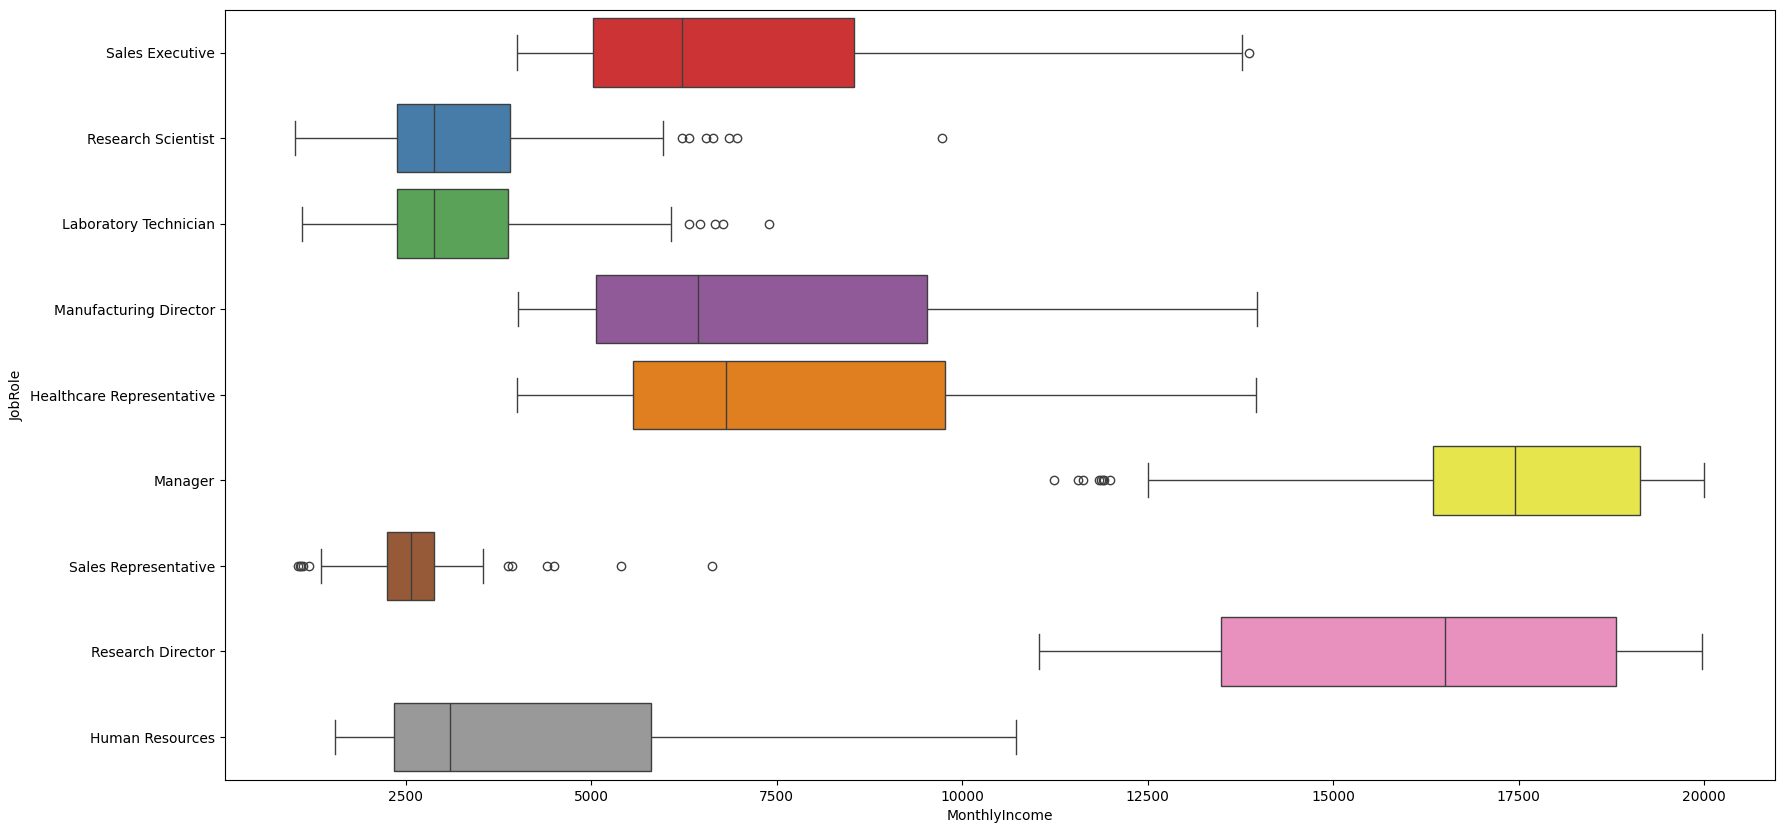

In [532]:
# kita akan melihat monthly income vs job role
plt.figure(figsize=(20,10))
sns.boxplot(x='MonthlyIncome',y='JobRole',data=df,palette="Set1")

Boxplot ini menunjukkan bahwa MonthlyIncome bervariasi signifikan antar JobRole, di mana Research Director dan Manager memiliki pendapatan tertinggi, sedangkan Sales Representative memiliki pendapatan terendah.


## Transform dan Membagi Dataset

In [533]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   int64 
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

kita akan melakukan one hot encoding untuk kolom kategorikal kita yaitu businesstravel , department , educationfield , gender , jobrole dan marital status

In [534]:
# pilih kolom kategorikal
categorical_cols = ['BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus']
X_cat = df[categorical_cols]

In [535]:
X_cat

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus
0,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single
1,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married
2,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single
3,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married
4,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married
...,...,...,...,...,...,...
1465,Travel_Frequently,Research & Development,Medical,Male,Laboratory Technician,Married
1466,Travel_Rarely,Research & Development,Medical,Male,Healthcare Representative,Married
1467,Travel_Rarely,Research & Development,Life Sciences,Male,Manufacturing Director,Married
1468,Travel_Frequently,Sales,Medical,Male,Sales Executive,Married


In [536]:
# lakukan one hot encoding
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
X_cat = onehotencoder.fit_transform(X_cat).toarray()

In [537]:
X_cat.shape

(1470, 26)

In [538]:
X_cat = pd.DataFrame(X_cat)

In [539]:
X_cat

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1466,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1467,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1468,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [540]:
# ini adalah kolom numerik dan kita harus drop attrition
X_numerik = df.drop(['Attrition','BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus'],axis=1)
X_numerik

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1102,1,2,2,94,3,2,4,5993,...,3,1,0,8,0,1,6,4,0,5
1,49,279,8,1,3,61,2,2,2,5130,...,4,4,1,10,3,3,10,7,1,7
2,37,1373,2,2,4,92,2,1,3,2090,...,3,2,0,7,3,3,0,0,0,0
3,33,1392,3,4,4,56,3,1,3,2909,...,3,3,0,8,3,3,8,7,3,0
4,27,591,2,1,1,40,3,1,2,3468,...,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,3,41,4,2,4,2571,...,3,3,1,17,3,3,5,2,0,3
1466,39,613,6,1,4,42,2,3,1,9991,...,3,1,1,9,5,3,7,7,1,7
1467,27,155,4,3,2,87,4,2,2,6142,...,4,2,1,6,0,3,6,2,0,3
1468,49,1023,2,3,4,63,2,2,2,5390,...,3,4,0,17,3,2,9,6,0,8


In [541]:
X_gabungan = pd.concat([X_cat,X_numerik],axis=1)
X_gabungan

,0,1,2,3,4,5,6,7,8,9,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,3,1,0,8,0,1,6,4,0,5
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,4,4,1,10,3,3,10,7,1,7
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3,2,0,7,3,3,0,0,0,0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,3,3,0,8,3,3,8,7,3,0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,3,3,1,17,3,3,5,2,0,3
1466,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,3,1,1,9,5,3,7,7,1,7
1467,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,4,2,1,6,0,3,6,2,0,3
1468,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,3,4,0,17,3,2,9,6,0,8


In [542]:
X_gabungan.columns = X_gabungan.columns.astype(str)
X = X_gabungan

In [543]:
X

,0,1,2,3,4,5,6,7,8,9,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,3,1,0,8,0,1,6,4,0,5
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,4,4,1,10,3,3,10,7,1,7
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3,2,0,7,3,3,0,0,0,0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,3,3,0,8,3,3,8,7,3,0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,3,3,1,17,3,3,5,2,0,3
1466,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,3,1,1,9,5,3,7,7,1,7
1467,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,4,2,1,6,0,3,6,2,0,3
1468,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,3,4,0,17,3,2,9,6,0,8


In [544]:
y = df['Attrition']
y

,Attrition
0,1
1,0
2,1
3,0
4,0
...,...
1465,0
1466,0
1467,0
1468,0


In [545]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_SEED
)

In [546]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Handling Imbalanced Dataset

In [547]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train, y_train = smote_tomek.fit_resample(X_train, y_train)


## Modelling

pada kesempatan kali ini , saya akan menggunakan 3 model untuk melakukan prediksi yaitu Logistic Regression, Random Forest dan Artificial Neural Network (ANN)

### Logistic Regression

In [548]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model1 = LogisticRegression(random_state=RANDOM_SEED)
model1.fit(X_train,y_train)

y_pred = model1.predict(X_test)

In [549]:
y_pred

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0])

In [550]:
from sklearn.metrics import confusion_matrix , classification_report

print('akurasi {} %'.format(100*accuracy_score(y_test,y_pred)))

akurasi 77.55102040816327 %


<Axes: >

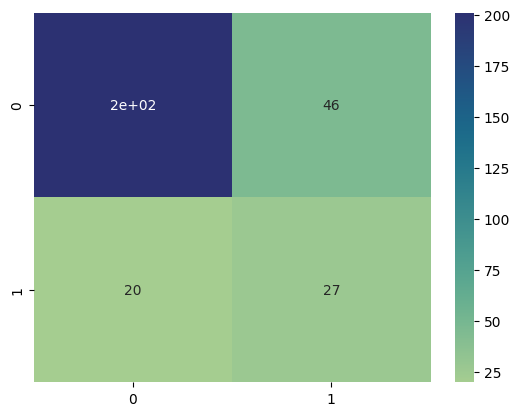

In [551]:
# testing set performance
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,cmap='crest')

In [552]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       247
           1       0.37      0.57      0.45        47

    accuracy                           0.78       294
   macro avg       0.64      0.69      0.65       294
weighted avg       0.82      0.78      0.79       294



## Random Forest Classifier

In [553]:
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier(random_state=RANDOM_SEED)
model2.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [554]:
y_pred = model2.predict(X_test)

<Axes: >

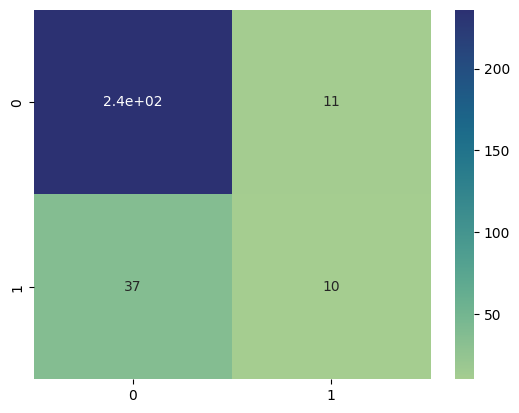

In [555]:
# testing set performance
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,cmap='crest')

In [556]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       247
           1       0.48      0.21      0.29        47

    accuracy                           0.84       294
   macro avg       0.67      0.58      0.60       294
weighted avg       0.80      0.84      0.81       294



### Artificial Neural Network

In [557]:
import tensorflow as tf

In [558]:
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Dense(units=500,activation='relu',input_shape=(X_train.shape[1],)))
model3.add(tf.keras.layers.Dense(units=500,activation='relu'))
model3.add(tf.keras.layers.Dense(units=500,activation='relu'))
model3.add(tf.keras.layers.Dense(units=500,activation='relu'))
model3.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [559]:
model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 500)            │        25,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 777,501 (2.97 MB)

 Trainable params: 777,501 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

In [560]:
model3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [561]:
epochs_hist = model3.fit(X_train,y_train,epochs=100,batch_size=50)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7351 - loss: 0.5170
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9204 - loss: 0.2169
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9707 - loss: 0.0934
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9767 - loss: 0.0641
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9828 - loss: 0.0583
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9933 - loss: 0.0191
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9839 - loss: 0.0357
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9904 - loss: 0.0371
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9865 - loss: 0.0406
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9944 - loss: 0.0095
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0041
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

In [562]:
y_pred = model3.predict(X_test)
y_pred = (y_pred > 0.5)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [563]:
y_pred

array([[False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [

In [564]:
epochs_hist.history.keys()

dict_keys(['accuracy', 'loss'])

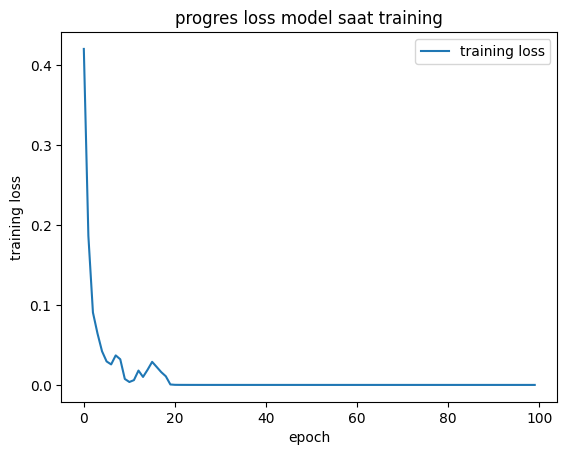

In [565]:
plt.plot(epochs_hist.history['loss'])
plt.title('progres loss model saat training')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.legend(['training loss'])

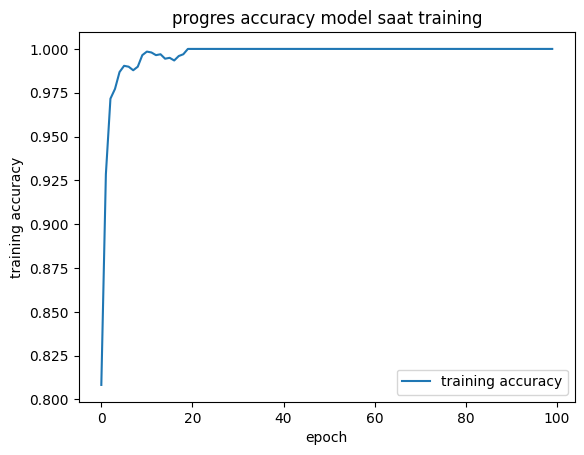

In [566]:
plt.plot(epochs_hist.history['accuracy'])
plt.title('progres accuracy model saat training')
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.legend(['training accuracy'])

<Axes: >

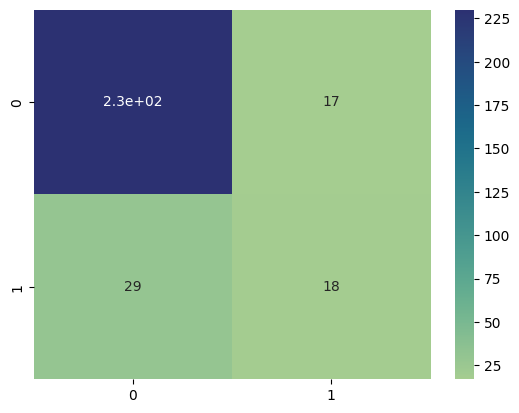

In [567]:
# testing set performance
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,cmap='crest')

In [568]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       247
           1       0.51      0.38      0.44        47

    accuracy                           0.84       294
   macro avg       0.70      0.66      0.67       294
weighted avg       0.83      0.84      0.83       294



### Menghitung Probabilitas setiap Model

In [569]:
lr_probs = model1.fit(X_train, y_train).predict_proba(X_test)[:, 1]

rf_probs = model2.fit(X_train, y_train).predict_proba(X_test)[:, 1]

ann_probs = model3.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


### Menghitung ROC-AUC Score

In [570]:
lr_auc = roc_auc_score(y_test, lr_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
ann_auc = roc_auc_score(y_test, ann_probs)

print(f'Logistic Regression ROC AUC: {lr_auc:.4f}')
print(f'Random Forest ROC AUC: {rf_auc:.4f}')
print(f'ANN ROC AUC: {ann_auc:.4f}')

Logistic Regression ROC AUC: 0.7840
Random Forest ROC AUC: 0.7976
ANN ROC AUC: 0.7407


### Plot Kurva ROC

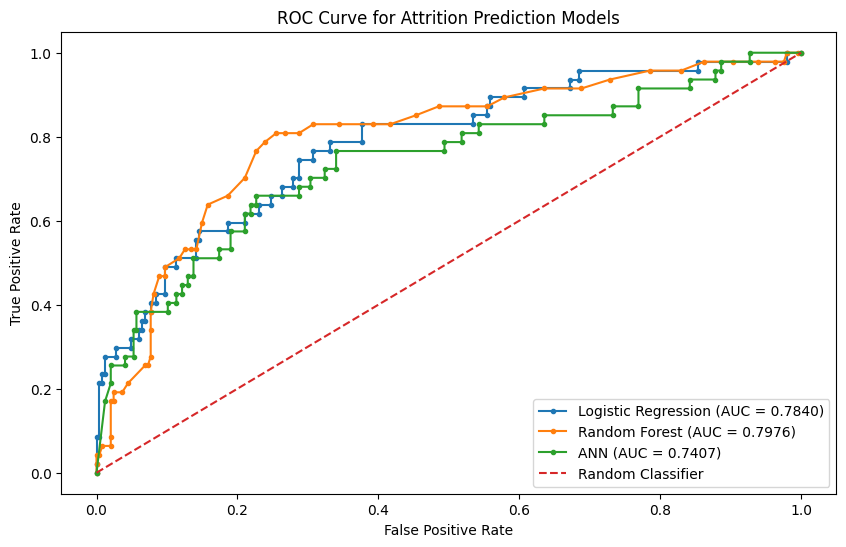

In [571]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
ann_fpr, ann_tpr, _ = roc_curve(y_test, ann_probs)

plt.figure(figsize=(10, 6))
plt.plot(lr_fpr, lr_tpr, marker='.', label=f'Logistic Regression (AUC = {lr_auc:.4f})')
plt.plot(rf_fpr, rf_tpr, marker='.', label=f'Random Forest (AUC = {rf_auc:.4f})')
plt.plot(ann_fpr, ann_tpr, marker='.', label=f'ANN (AUC = {ann_auc:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attrition Prediction Models')
plt.legend()
plt.show()

## Modelling Improvement part 2

perhatikan bahwa kita bisa melihat walaupun akurasi sudah bagus , namun jika kita berfokus untuk membuat model yang ditujukan untuk melakukan prediksi kepada orang yang ingin keluar sehingga kita mencoba mencegahnya maka metrik yang penting adalah recall pada kelas 1 .

disini kita akan melakukan feature engineering lanjutan yang berupa improvement dari proses sebelumnya dan modelling dengan cara yang jauh lebih baik

### Further Feature Engineering

Saya menambahkan beberapa fitur baru yang relevan secara bisnis untuk memperkaya model prediksi attrition:

* **`tenure_ratio`**: rasio lama bekerja di perusahaan saat ini terhadap total pengalaman kerja → mengukur loyalitas karyawan.
* **`recent_promo`**: flag jika karyawan baru mendapat promosi → promosi menurunkan risiko keluar.
* **`long_commute`**: flag jika jarak rumah > 10 km → commute panjang meningkatkan risiko keluar.
* **`age_bucket`**: pengelompokan umur (`18-25`, `26-30`, `31-35`, `36-45`, `46+`) → usia muda lebih mobile, senior lebih stabil.
* **`seniority_bucket`**: kategori berdasarkan `JobLevel` → level rendah lebih mobile, level tinggi lebih stabil.


In [572]:
df = df_copy

In [573]:
df['tenure_ratio'] = df['YearsAtCompany'] / (df['TotalWorkingYears'].replace(0, np.nan))
df['tenure_ratio'] = df['tenure_ratio'].fillna(0)

df['recent_promo'] = (df['YearsSinceLastPromotion'] == 0).astype(int)
df['long_commute'] = (df['DistanceFromHome'] > 10).astype(int)
df['age_bucket'] = pd.cut(df['Age'], bins=[17,25,30,35,45,60], labels=['18-25','26-30','31-35','36-45','46+'])
df['seniority_bucket'] = df['JobLevel'].astype(str)  # treat as categorical for encoding

In [574]:
df[['tenure_ratio','recent_promo','long_commute','age_bucket','seniority_bucket']].head()

,tenure_ratio,recent_promo,long_commute,age_bucket,seniority_bucket
0,0.750000,1,0,36-45,2
1,1.000000,0,0,46+,2
2,0.000000,1,0,36-45,1
3,1.000000,0,0,31-35,1
4,0.333333,0,0,26-30,1


array([[<Axes: title={'center': 'tenure_ratio'}>,
        <Axes: title={'center': 'recent_promo'}>],
       [<Axes: title={'center': 'long_commute'}>, <Axes: >]], dtype=object)

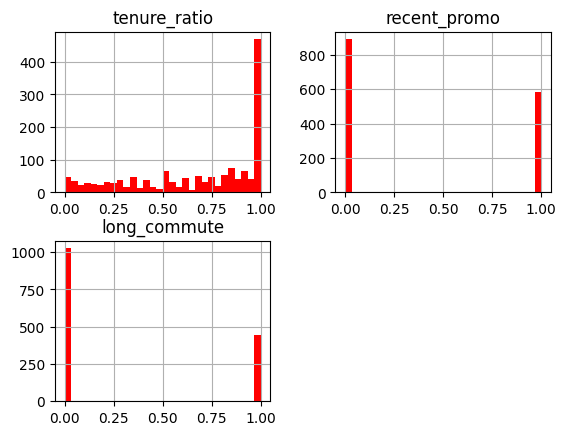

In [575]:
df[['tenure_ratio','recent_promo','long_commute','age_bucket','seniority_bucket']].hist(bins= 30,color='r')

In [576]:
# kita akan memisahkan kolom numerik dan yang bukan
target = 'Attrition'
# kolom numerik kecuali target
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
# remove target
numeric_cols = [c for c in numeric_cols if c != target]

# categorical features
categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()
categorical_cols = [c for c in categorical_cols if c not in [target]]


In [577]:
print("kolom numerik :", len(numeric_cols), numeric_cols[:15])
print("kolom kategorikal :", len(categorical_cols), categorical_cols[:15])

kolom numerik : 27 ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating']
kolom kategorikal : 8 ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'age_bucket', 'seniority_bucket']


In [578]:
X = df.drop(columns=[target])
y = df[target]

In [579]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_SEED
)

In [580]:
print("ukuran train:", X_train.shape, "ukuran test:", X_test.shape)

ukuran train: (1176, 35) ukuran test: (294, 35)


### Preprocessing Pipeline

kita akan membuat preprocessing pipeline agar data siap untuk model: fitur numerik diskalakan dengan **StandardScaler**, fitur kategorikal sedikit kategori diubah dengan **OneHotEncoder**, sedangkan fitur dengan banyak kategori diproses memakai **TargetEncoder** untuk mencegah dimensi membesar. Semua langkah digabung dalam **ColumnTransformer** sehingga preprocessing konsisten dan bebas data leakage.

In [581]:
HIGH_CARDINALITY = 10

low_card_cols = [c for c in categorical_cols if X_train[c].nunique() <= HIGH_CARDINALITY]
high_card_cols = [c for c in categorical_cols if X_train[c].nunique() > HIGH_CARDINALITY]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

low_card_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

high_card_transformer = Pipeline(steps=[
    ('target_enc', ce.TargetEncoder(cols=high_card_cols))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('lowcat', low_card_transformer, low_card_cols),
], remainder='drop', sparse_threshold=0)

In [582]:
print("low_card_cols:", low_card_cols)
print("high_card_cols:", high_card_cols)

low_card_cols: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'age_bucket', 'seniority_bucket']
high_card_cols: []


In [583]:
def make_imb_pipeline(clf, use_smote_tomek=True, target_encode_cols=None):
    steps = []
    if target_encode_cols:
        steps.append(('target_enc', ce.TargetEncoder(cols=target_encode_cols)))
    steps.append(('preprocessor', preprocessor))
    if use_smote_tomek:
        steps.append(('smote_tomek', SMOTETomek(random_state=RANDOM_SEED)))
    steps.append(('clf', clf))
    return ImbPipeline(steps=steps)

### Modelling dengan 3 Model

In [584]:
# buat baseline model

from sklearn.model_selection import cross_validate
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

lr = LogisticRegression(random_state=RANDOM_SEED, max_iter=2000)
rf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                            random_state=RANDOM_SEED, n_jobs=-1)

pip_lr = make_imb_pipeline(lr, use_smote_tomek=False, target_encode_cols=high_card_cols)
pip_rf = make_imb_pipeline(rf, use_smote_tomek=True, target_encode_cols=high_card_cols)
pip_xgb = make_imb_pipeline(xgb_clf, use_smote_tomek=True, target_encode_cols=high_card_cols)

scoring = {'recall_1': 'recall', 'avg_prec': 'average_precision', 'f1': 'f1'}

def cv_eval(pipeline, X, y, skf, scoring):
    res = cross_validate(pipeline, X, y, cv=skf, scoring=scoring,
                         return_train_score=False, n_jobs=-1)
    print("Scores:")
    for k,v in res.items():
        print(k, np.mean(v), "+-", np.std(v))
    return res

print("Logistic Regression baseline")
cv_eval(pip_lr, X_train, y_train, skf, scoring)
print('\n')
print("RandomForest baseline")
cv_eval(pip_rf, X_train, y_train, skf, scoring)
print('\n')
print("XGBoost baseline")
cv_eval(pip_xgb, X_train, y_train, skf, scoring)

Logistic Regression baseline
Scores:
fit_time 0.04319033622741699 +- 0.004209125965133254
score_time 0.029980564117431642 +- 0.005697949053833112
test_recall_1 0.5 +- 0.09266745716662637
test_avg_prec 0.682244775899224 +- 0.05073493501218662
test_f1 0.604640588888082 +- 0.07090114771370679


RandomForest baseline
Scores:
fit_time 0.6204455852508545 +- 0.1104463640317778
score_time 0.09265260696411133 +- 0.0061738818516353594
test_recall_1 0.29473684210526313 +- 0.09326339550878607
test_avg_prec 0.5728180611468675 +- 0.0782957222097718
test_f1 0.4069592132934451 +- 0.08525175304860796


XGBoost baseline
Scores:
fit_time 0.9804064750671386 +- 0.18990709062611077
score_time 0.051302766799926756 +- 0.017619466911759963
test_recall_1 0.39473684210526316 +- 0.062274524032627544
test_avg_prec 0.5860911800655357 +- 0.06772412893586191
test_f1 0.5005091256320666 +- 0.04876334535809981


{'fit_time': array([1.05244493, 1.14362049, 1.13799715, 0.93646026, 0.63150954]),
 'score_time': array([0.05561304, 0.07108712, 0.06834865, 0.0323751 , 0.02908993]),
 'test_recall_1': array([0.36842105, 0.31578947, 0.36842105, 0.42105263, 0.5       ]),
 'test_avg_prec': array([0.61644489, 0.46921067, 0.58503657, 0.6773899 , 0.58237388]),
 'test_f1': array([0.50909091, 0.40677966, 0.50909091, 0.54237288, 0.53521127])}

dapat dilihat bahwa dari ketiga model , model logistic regression memiliki performa yang paling baik .

bisa dilihat bahwa disini logistic regression memiliki recall yang kuat dan stabil sehingga kita akan memilihnya menjadi model baseline

### Hyperparameter Tuning

In [585]:
# Hyperparameter tuning (Logistic Regression)
# Logistic Regression: kita fokus ke regularisasi & class_weight
param_dist = {
    'clf__penalty': ['l1', 'l2'],               # L1 = Lasso, L2 = Ridge
    'clf__C': np.logspace(-3, 2, 10),            # Regularization strength
    'clf__solver': ['liblinear', 'saga'],        # solver yg support L1 & L2
    'clf__class_weight': [None, 'balanced']      # handle imbalance
}

rand_search_lr = RandomizedSearchCV(
    pip_lr,
    param_distributions=param_dist,
    n_iter=20,
    scoring='recall',
    cv=skf,
    verbose=2,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rand_search_lr.fit(X_train, y_train)

print("Best params (LogReg):", rand_search_lr.best_params_)
print("Best CV recall (LogReg):", rand_search_lr.best_score_)

best_lr = rand_search_lr.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params (LogReg): {'clf__solver': 'liblinear', 'clf__penalty': 'l2', 'clf__class_weight': 'balanced', 'clf__C': np.float64(0.01291549665014884)}
Best CV recall (LogReg): 0.763157894736842


### Evaluasi dengan treshold default

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9397    0.7571    0.8386       247
           1     0.3684    0.7447    0.4930        47

    accuracy                         0.7551       294
   macro avg     0.6541    0.7509    0.6658       294
weighted avg     0.8484    0.7551    0.7833       294



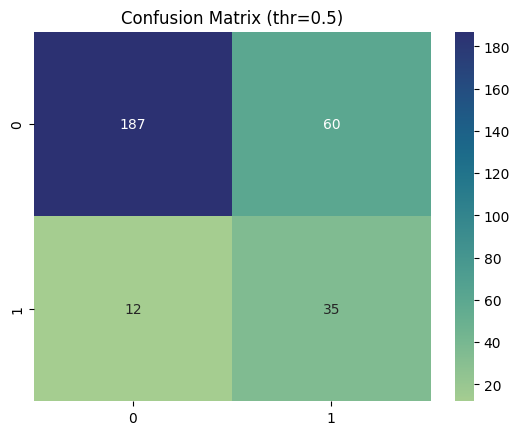

Average precision (PR-AUC): 0.630150163402468


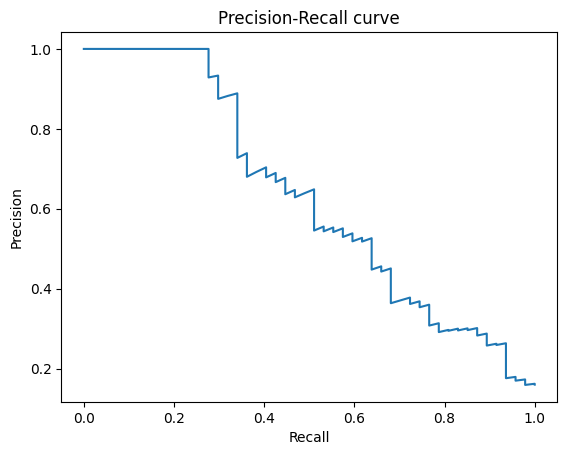

In [586]:
# Cell 11 — Evaluate tuned Logistic Regression on test set
probs = best_lr.predict_proba(X_test)[:,1]
preds = (probs >= 0.5).astype(int)

print("Classification report (threshold=0.5):")
print(classification_report(y_test, preds, digits=4))

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='crest')
plt.title("Confusion Matrix (thr=0.5)")
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, probs)
ap = average_precision_score(y_test, probs)
print("Average precision (PR-AUC):", ap)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.show()

### Treshold Tuning

disini saya melakukan treshold tuning dengan mengatur batas keputusan model untuk melakukan klasifikasi .

dalam konteks bisnis , kita bisa menggambarkan jika problem kita lebih fokus kepada mendeteksi karyawan yang keluar , maka metrik recall adalah hal yang penting .

disini kita mungkin mempengaruhi precision tapi kita akan mencoba untuk menemukan treshold terbaik dengan syarat precision yang tidak terlalu turun secara drastis

Chosen threshold (LogReg): 0.4837948411326414 with recall: 0.7659574468085106
Classification report (threshold tuned):
              precision    recall  f1-score   support

           0     0.9427    0.7328    0.8246       247
           1     0.3529    0.7660    0.4832        47

    accuracy                         0.7381       294
   macro avg     0.6478    0.7494    0.6539       294
weighted avg     0.8484    0.7381    0.7700       294



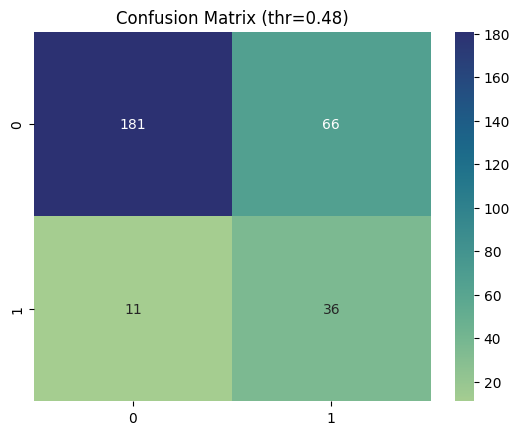

In [587]:
# Cell 12 — Threshold tuning (Logistic Regression)
min_precision = 0.35
best_thr = 0.5
best_recall = 0

for p, r, t in zip(precision, recall, np.append(thresholds, 1.0)):
    if p >= min_precision and r > best_recall:
        best_recall = r
        best_thr = t

print("Chosen threshold (LogReg):", best_thr, "with recall:", best_recall)

# Evaluate dengan threshold baru
preds_new = (probs >= best_thr).astype(int)
print("Classification report (threshold tuned):")
print(classification_report(y_test, preds_new, digits=4))

cm = confusion_matrix(y_test, preds_new)
sns.heatmap(cm, annot=True, fmt='d', cmap='crest')
plt.title(f"Confusion Matrix (thr={best_thr:.2f})")
plt.show()

## Kesimpulan Proyek Analisis dan Prediksi Employee Attrition

Berdasarkan analisis dan pemodelan yang telah dilakukan pada dataset karyawan:

### Temuan Utama dari Analisis Data:

*   Dataset tidak memiliki *missing values*, sehingga data siap digunakan untuk analisis dan pemodelan.
*   Fitur-fitur seperti `EmployeeCount`, `StandardHours`, dan `Over18` dihapus karena nilainya konstan, serta `EmployeeNumber` karena merupakan ID unik.
*   Karyawan yang meninggalkan perusahaan (*left*) memiliki karakteristik yang berbeda secara statistik dibandingkan dengan karyawan yang bertahan (*stayed*). Beberapa perbedaan mencolok meliputi:
    *   Rata-rata umur pegawai yang *left* lebih muda (33 tahun) dibandingkan yang *stayed* (37 tahun).
    *   Tingkat upah harian (`DailyRate`) karyawan yang *stayed* cenderung lebih tinggi.
    *   Karyawan yang *stayed* pada umumnya tinggal lebih dekat dari rumah (`DistanceFromHome`).
    *   Tingkat kepuasan terhadap lingkungan kerja (`EnvironmentSatisfaction`) dan pekerjaan (`JobSatisfaction`) lebih tinggi pada karyawan yang *stayed*.
    *   Karyawan yang *stayed* cenderung memiliki tingkat opsi saham (`StockOptionLevel`) yang lebih tinggi.
*   Analisis korelasi menunjukkan hubungan kuat antara beberapa fitur numerik, seperti `JobLevel`, `MonthlyIncome`, dan `TotalWorkingYears`.
*   Visualisasi data mengungkapkan beberapa tren terkait *attrition*:
    *   Usia 28 hingga 31 tahun menunjukkan rasio *attrition* yang tinggi.
    *   Karyawan dengan status perkawinan 'Single' memiliki angka *attrition* yang tinggi.
    *   *Job Role* 'Sales Representative' memiliki rasio *attrition* yang sangat tinggi.
    *   Tingkat *Job Involvement* dan *Job Level* yang rendah berkorelasi dengan *attrition* yang lebih tinggi.
    *   Jarak dari rumah yang lebih dari 10km dan masa kerja yang singkat dengan manajer saat ini (`YearsWithCurrManager`) juga terkait dengan peningkatan risiko *attrition*.
*   Tidak ditemukan perbedaan signifikan dalam pendapatan bulanan antara gender.

### Hasil Pemodelan:

Dilakukan pemodelan menggunakan Logistic Regression, Random Forest, dan Artificial Neural Network (ANN) setelah melakukan *feature engineering* tambahan, *preprocessing* data (termasuk *scaling* dan *one-hot encoding*), dan penanganan *imbalanced dataset* menggunakan SMOTETomek.

Evaluasi awal menggunakan *cross-validation* menunjukkan bahwa Logistic Regression memiliki performa *recall* yang paling baik di antara ketiga model.

Setelah melakukan *hyperparameter tuning* pada Logistic Regression dengan tujuan meningkatkan *recall* (untuk mendeteksi karyawan yang berisiko *left*), didapatkan *threshold* keputusan yang optimal di angka sekitar 0.48. Evaluasi model Logistic Regression terbaik pada *test set* dengan *threshold* ini menghasilkan metrik berikut:

*   **Precision (Kelas 1):** 0.3529
*   **Recall (Kelas 1):** 0.7660
*   **F1-score (Kelas 1):** 0.4832
*   **Overall Accuracy:** 0.7381
*   **ROC AUC:** 0.7840
*   **Average Precision (PR-AUC):** 0.6302

Dengan *threshold* yang disetel, model Logistic Regression mampu mendeteksi sekitar 76.6% dari karyawan yang sebenarnya akan *left* (*recall* tinggi), yang sangat relevan jika tujuan utama adalah identifikasi dini untuk intervensi pencegahan. Meskipun *precision* (proporsi prediksi *left* yang benar-benar *left*) sedikit lebih rendah, ini merupakan *trade-off* yang dapat diterima tergantung pada prioritas bisnis.